In [1]:
data_dir = '/home/cadel/projects/thesis/UNSWThesis/data/def'
uces_filename = 'ste08_3_of_5_9c8ec52.deduce.fa'

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import os
from Bio import SeqIO
import constants
sns.set_context(constants.sns_context)
sns.set_style(constants.sns_style)


# Load UCEs and instances

In [3]:
def read_fasta_sequences(filename: str):
    return SeqIO.parse(filename, "fasta")

uces = pd.DataFrame([(x.id, str(x.seq)) for x in read_fasta_sequences(os.path.join(data_dir, uces_filename))], columns=['id', 'seq']).set_index('id', drop=False)

uces["length"] = uces["seq"].map(lambda x: len(x))
uces = uces.astype({'id': 'int32'})
uces

,id,seq,length
id,,,
0,0,AGGTTCCAGTTTCATTGCTGAAGTATGCACCAAACAACGGTGGCCT...,138
1,1,AAAGTTTGTCCCTTTATTTTCCATATATCCTGGTTCTGCCTCAGCT...,110
2,2,GACCTCTGTCCACAAAACTCCATGTTAGGTAGTTCACTGTGTAAAA...,166
3,3,AAGCTAATATTATCTATTTCCCAAGTGAAAAGAGTCCTTCCAGTCC...,153
4,4,CCCCCCCATAAGGTGCTTCTTGTTATGCCTGACCTTCAGATTTTCA...,113
...,...,...,...
26241,26241,AGCTGATCACTGTCTCTTTGACGTGGCTGCAAATGTTACCTTTCTT...,108
26242,26242,AAAGGGCTTGCAAACATTTTTGTTAATTATGTATTACAGCTGTCCT...,105
26243,26243,TTTTGCCTCTATGTCTCTTAAAATTTTAATTAAAAATACTCTTTCC...,110


In [4]:
def read_bed(f):
    df = pd.read_csv(f, delimiter="\t", names=["chr", "start", "end", "id", "score"])
    df["genome"] = np.repeat(os.path.basename(f), len(df))
    return df

uce_instances = pd.concat([read_bed(os.path.join(data_dir, bed)) for bed in os.listdir(data_dir) if bed.endswith("bed")])
uce_instances["length"] = uce_instances.end - uce_instances.start
uce_instances

,chr,start,end,id,score,genome,length
0,chr25,22608010,22608148,0,100.0,ste08_3_of_5_9c8ec52-bosTau2.bed,138
1,chr3,8361748,8361858,1,100.0,ste08_3_of_5_9c8ec52-bosTau2.bed,110
2,chr10,18783548,18783714,2,100.0,ste08_3_of_5_9c8ec52-bosTau2.bed,166
3,chr10,19605031,19605184,3,100.0,ste08_3_of_5_9c8ec52-bosTau2.bed,153
4,chr28,30945537,30945644,5,100.0,ste08_3_of_5_9c8ec52-bosTau2.bed,107
...,...,...,...,...,...,...,...
75934,chr8,124484882,124484992,26239,100.0,ste08_3_of_5_9c8ec52-mm8.bed,110
75935,chr2,72738369,72738513,26240,100.0,ste08_3_of_5_9c8ec52-mm8.bed,144
75936,chr18,84567404,84567509,26242,100.0,ste08_3_of_5_9c8ec52-mm8.bed,105
75937,chr9,29068299,29068521,26244,100.0,ste08_3_of_5_9c8ec52-mm8.bed,222


# UCE length distribution

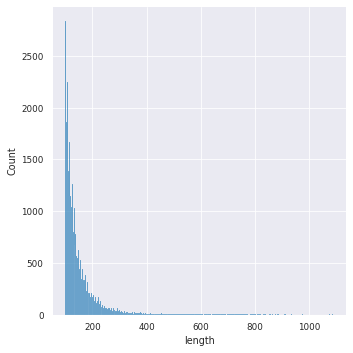

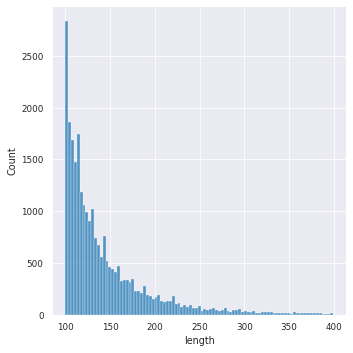

In [5]:
sns.displot(uces, x="length")
sns.displot(uces[uces["length"] < 400], x="length")

## UCE counts across all matched genomes

/tmp/ipykernel_67098/4207983794.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers_removed = outliers_removed[(np.abs(stats.zscore(grouped["count"])) < 3)]


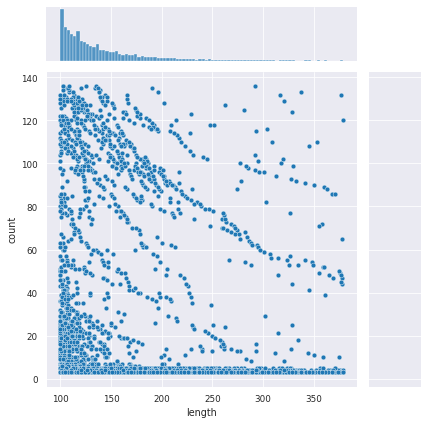

In [6]:
grouped = uce_instances.groupby('id').agg(
    id=pd.NamedAgg(column="id", aggfunc="first"),
    count=pd.NamedAgg(column="id", aggfunc="size"),
    length=pd.NamedAgg(column="length", aggfunc="first")
)

grouped["logcount"] = np.log10(grouped["count"])

outliers_removed = grouped[(np.abs(stats.zscore(grouped["length"])) < 3)]
outliers_removed = outliers_removed[(np.abs(stats.zscore(grouped["count"])) < 3)]

sns.jointplot(data=outliers_removed, x="length", y="count")

## Unique genomes per UCE

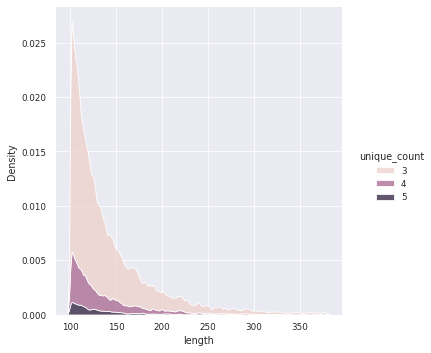

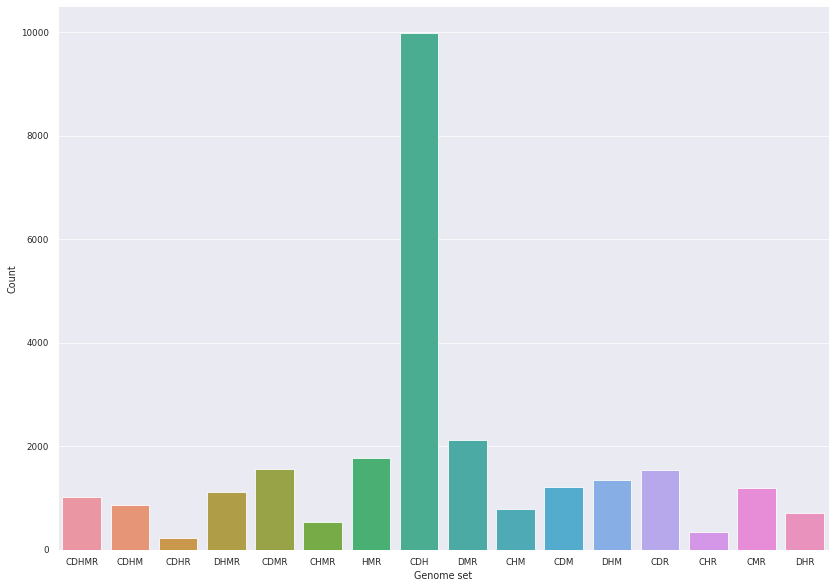

In [13]:
nicenames = {
    "ste08_3_of_5_9c8ec52-bosTau2.bed": "C",
    "ste08_3_of_5_9c8ec52-canFam2.bed": "D", 
    "ste08_3_of_5_9c8ec52-hg18.bed": "H",
    "ste08_3_of_5_9c8ec52-rn4.bed": "R",
    "ste08_3_of_5_9c8ec52-mm8.bed": "M",
}

grouped = uce_instances.groupby('id').agg(
    id=pd.NamedAgg(column="id", aggfunc="first"),
    unique_count=pd.NamedAgg(column="genome", aggfunc=lambda xs: len(set(xs))),
        count=pd.NamedAgg(column="id", aggfunc="size"),
        the_genomes=pd.NamedAgg(column="genome", aggfunc=lambda xs: "".join([nicenames[x] for x in sorted(set(xs))])),

    length=pd.NamedAgg(column="length", aggfunc="first")
)

outliers_removed = grouped[(np.abs(stats.zscore(grouped["length"])) < 3)]

sns.displot(data=outliers_removed, x="length", hue="unique_count", kind="kde", bw_adjust=.15, multiple="stack")
#sns.jointplot(data=grouped, x="length", y="unique_count")
#sns.set(rc={'figure.figsize':(11.7,8.27)})

ste_set_plot = sns.catplot(data=grouped, x="the_genomes", kind="count", height=8.27, aspect=11.7/8.27, order=["CDHMR", "CDHM", "CDHR", "DHMR", "CDMR", "CHMR", "HMR", "CDH", "DMR", "CHM", "CDM", "DHM", "CDR", "CHR", "CMR", "DHR"])
ste_set_plot.set_axis_labels("Genome set", "Count")
ste_set_plot.savefig(os.path.join(constants.image_out_dir, "ste_set_plot.pdf"))



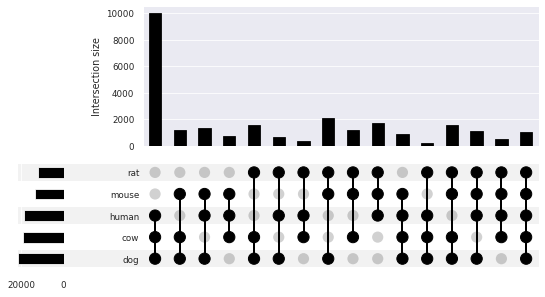

In [37]:
import upsetplot
from collections import defaultdict
import matplotlib.pyplot as plt

nicenames2 = {
    "ste08_3_of_5_9c8ec52-bosTau2.bed": "cow",
    "ste08_3_of_5_9c8ec52-canFam2.bed": "dog", 
    "ste08_3_of_5_9c8ec52-hg18.bed": "human",
    "ste08_3_of_5_9c8ec52-rn4.bed": "rat",
    "ste08_3_of_5_9c8ec52-mm8.bed": "mouse",
}

grouped = uce_instances.groupby('id').agg(
    id=pd.NamedAgg(column="id", aggfunc="first"),
    unique_count=pd.NamedAgg(column="genome", aggfunc=lambda xs: len(set(xs))),
        count=pd.NamedAgg(column="id", aggfunc="size"),
        the_genomes=pd.NamedAgg(column="genome", aggfunc=lambda xs: ",".join([nicenames2[x] for x in sorted(set(xs))])),

    length=pd.NamedAgg(column="length", aggfunc="first")
)

sets = defaultdict(list)

for r in grouped.to_records(index=False):
    #print(r[3].split(","))
    #print(r[0])
    for g in r[3].split(","):
        sets[g].append(r[0])
    
upsetplot.plot(upsetplot.from_contents(sets))
plt.savefig(os.path.join(constants.image_out_dir, "ste_set_upsetplot.pdf"))

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

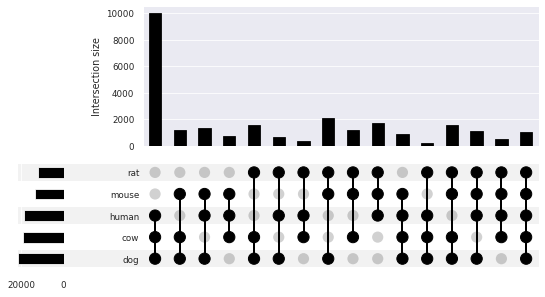

In [32]:
sets = defaultdict(list)

for i in range(0, 26246):
    for r in uce_instances[uce_instances.id == i].to_records(index=False):
        if i not in sets[nicenames2[r[5]]]:
            sets[nicenames2[r[5]]].append(i)

upsetplot.plot(upsetplot.from_contents(sets))

In [9]:
ALL_PARAMS = {"min_length", "min_appearances", "min_identity"}
PARAM_MINS = {"min_length": 50, "min_appearances": 1, "min_identity": 70}

def count_uces_by_parameter_set(uces, min_length, min_identity, min_appearances):
#     df = uces[(uces.length >= min_length)]
    df = uces
    max_lengths = df.groupby(["name"]).aggregate(max_length=pd.NamedAgg(column="length", aggfunc="max"))
    df["matches"] = df["score"] / 100 * df["length"]
    df["matches"] = np.floor(df["matches"])
    df = df.join(max_lengths, on="name")
    df["adjusted_identity"] = np.floor(df["matches"] / df["max_length"] * 100)

    df = df[(df.adjusted_identity >= min_identity)]

    grouped = df.groupby(["name"]).size()
    return len(grouped[grouped >= min_appearances])

# count_uces_by_parameter_set(uces, {"min_length": 200, "min_appearances": 2, "min_identity": 100})

In [10]:
min_length = uces["length"].min()
max_length = uces["length"].max()
min_appearances = 1
max_appearances = 5
min_identity = 90
max_identity = uces["score"].max()
print(min_identity)
def get_length_data():
    data = pd.Series(np.arange(min_length, 774, 10)).to_frame("min_length")
    data["min_appearances"] = 1
    data["min_identity"] = min_identity

    data["uce_count"] = data.apply(lambda row: count_uces_by_parameter_set(uces, row.min_length, row.min_identity, row.min_appearances), axis=1)
    return data

def get_identity_data():
    data = pd.Series(np.arange(min_identity, max_identity + 1)).to_frame("min_identity")
    data["min_appearances"] = 1
    data["min_length"] = min_length

    data["uce_count"] = data.apply(lambda row: count_uces_by_parameter_set(uces, row.min_length, row.min_identity, row.min_appearances), axis=1)
    return data

KeyError: 'score'

In [ ]:
idd = get_identity_data()
idd
#sns.relplot(data=get_identity_data(), x="adjusted_identity", y="uce_count")

In [ ]:
sns.relplot(data=idd, x="min_identity", y="uce_count")

In [ ]:
def count_ste08_uces(uces):
    df = uces[(uces.length >= 200) & (uces.score >= 100)]
    return df
    grouped = df.groupby(["name"]).size()
    return grouped
#     return grouped[grouped >= 3].size

df = count_ste08_uces(uces)
uces[uces.name == "candidate_806073"]
